In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'+'nue_delta_check/' 
output_filedir = outputdir
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.18/04


In [2]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [3]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

# Nue cross check
The filter must pass fewer than 45 electron neutrino events normalized to 6.6E20 POT
counted within a range of true neutrino energy between 50 MeV to 1.5 GeV using a
sample of ~300,000 cosmic-overlaid charged current electron neutrino interactions in the
TPC

In [52]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"nue_delta_check.root","RECREATE");
filename_overlay = 'NuCCana_deltaNC_V26.root'
tree_name = 'numuCCAna'

overlay = ROOT.TChain(tree_name + "/event","event")
overlay.Add( inputdir + filename_overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
print 'POT: ',pot_overlay

pot_run3G1 = 2.1e20
scale = pot_run3G1/pot_overlay
print scale

POT:  5.09021081942e+23
0.000412556586456


In [5]:
filename_overlay = filename_overlay+'out4.root'
tree_name = 't_out'

overlay_out = ROOT.TChain(tree_name, "t_out")
overlay_out.Add( inputdir + filename_overlay)

print 'Entries TTree: ',overlay.GetEntries()
print 'Entries Tout: ',overlay_out.GetEntries()

Entries TTree:  108840
Entries Tout:  108839


In [9]:
fidVol = '(Nu_Vx_sce>(-1.55) && Nu_Vx_sce<(254.8)) && (Nu_Vy_sce>(-115.53) && Nu_Vy_sce<(117.47)) &&(Nu_Vz_sce>(-0.1) && Nu_Vz_sce<(1036.9))'
MCfidVol = '(MCNu_Vx>(-1.55) && MCNu_Vx<(254.8)) && (MCNu_Vy>(-115.53) && MCNu_Vy<(117.47)) &&(MCNu_Vz>(-0.1) && MCNu_Vz<(1036.9))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
sample = [overlay,overlay_out]
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
fidVol = '(Nu_Vx_sce>(-1.55) && Nu_Vx_sce<(254.8)) && (Nu_Vy_sce>(-115.53) && Nu_Vy_sce<(117.47)) &&(Nu_Vz_sce>(-0.1) && Nu_Vz_sce<(1036.9))'
overlay.SetAlias('fidVol',fidVol)
overlay_out.SetAlias('fidVol',fidVol)
overlay.SetAlias('muon','(track_key == key_muon)')
overlay_out.SetAlias('muon','(track_key == key_muon)')

track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'
track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'

overlay.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)

overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

overlay.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [25]:

nue_tot_rate0 = overlay_out.GetEntries('')*scale
print 'Delta NC (tot): ', nue_tot_rate0

nue_tot_rate1 = overlay.GetEntries('MCfidVol')*scale
print 'Delta NC (tot in fidVol): ', nue_tot_rate1, '={:04.2f} %'.format((nue_tot_rate1*100.0)/nue_tot_rate0)

nue_tot_rate2 = overlay.GetEntries('MCfidVol && fidVol')*scale
print 'Delta NC (tot in fidVol, reco fidVol): ', nue_tot_rate2, '={:04.2f} %'.format((nue_tot_rate2*100.0)/nue_tot_rate1)

cut = 'MCfidVol && fidVol && \
        sqrt( pow(TrackStart_x_sce - MCNu_Vx,2) + pow(TrackStart_y_sce - MCNu_Vy,2) + pow(TrackStart_z_sce - MCNu_Vz,2) )<15'

nue_tot_rate3 = overlay.GetEntries(cut)*scale
print 'One track <15cm: ', nue_tot_rate3, '={:04.2f} %'.format((nue_tot_rate3*100.0)/nue_tot_rate1)


nue_tot_rate4 = overlay.GetEntries(cut+' && MCTrackPurity>0.5 && sqrt( pow(TrackStart_x_sce - MCTrackStart_x,2) + \
    pow(TrackStart_y_sce - MCTrackStart_y,2) + pow(TrackStart_z_sce - MCTrackStart_z,2) )<15')*scale
print 'one track < 15cm + high purity: ', nue_tot_rate4, '={:04.2f} %'.format((nue_tot_rate4*100.0)/nue_tot_rate1)

nue_tot_rate4 = overlay.GetEntries(cut+' && MCTrackPurity>0.5 && sqrt( pow(TrackStart_x_sce - MCTrackStart_x,2) + \
    pow(TrackStart_y_sce - MCTrackStart_y,2) + pow(TrackStart_z_sce - MCTrackStart_z,2) )<15 && NuShowers==0')*scale
print 'one track < 15cm + high purity, 0 shower: ', nue_tot_rate4, '={:04.2f} %'.format((nue_tot_rate4*100.0)/nue_tot_rate1)


Delta NC (tot):  44.9022463133
Delta NC (tot in fidVol):  38.3566235126 =85.42 %
Delta NC (tot in fidVol, reco fidVol):  25.4081224901 =66.24 %
One track <15cm:  10.3283541419 =26.93 %
one track < 15cm + high purity:  9.23837964051 =24.09 %
one track < 15cm + high purity, 0 shower:  0.00536323562393 =0.01 %


PDG:  -211  Numver of tracks:  0.148932933807
PDG:  -13  Numver of tracks:  0.00206278287806
PDG:  -11  Numver of tracks:  0.905561685562
PDG:  11  Numver of tracks:  1.14319431782
PDG:  13  Numver of tracks:  0.00123766972683
PDG:  211  Numver of tracks:  0.106439597905
PDG:  2212  Numver of tracks:  9.31800270081


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).


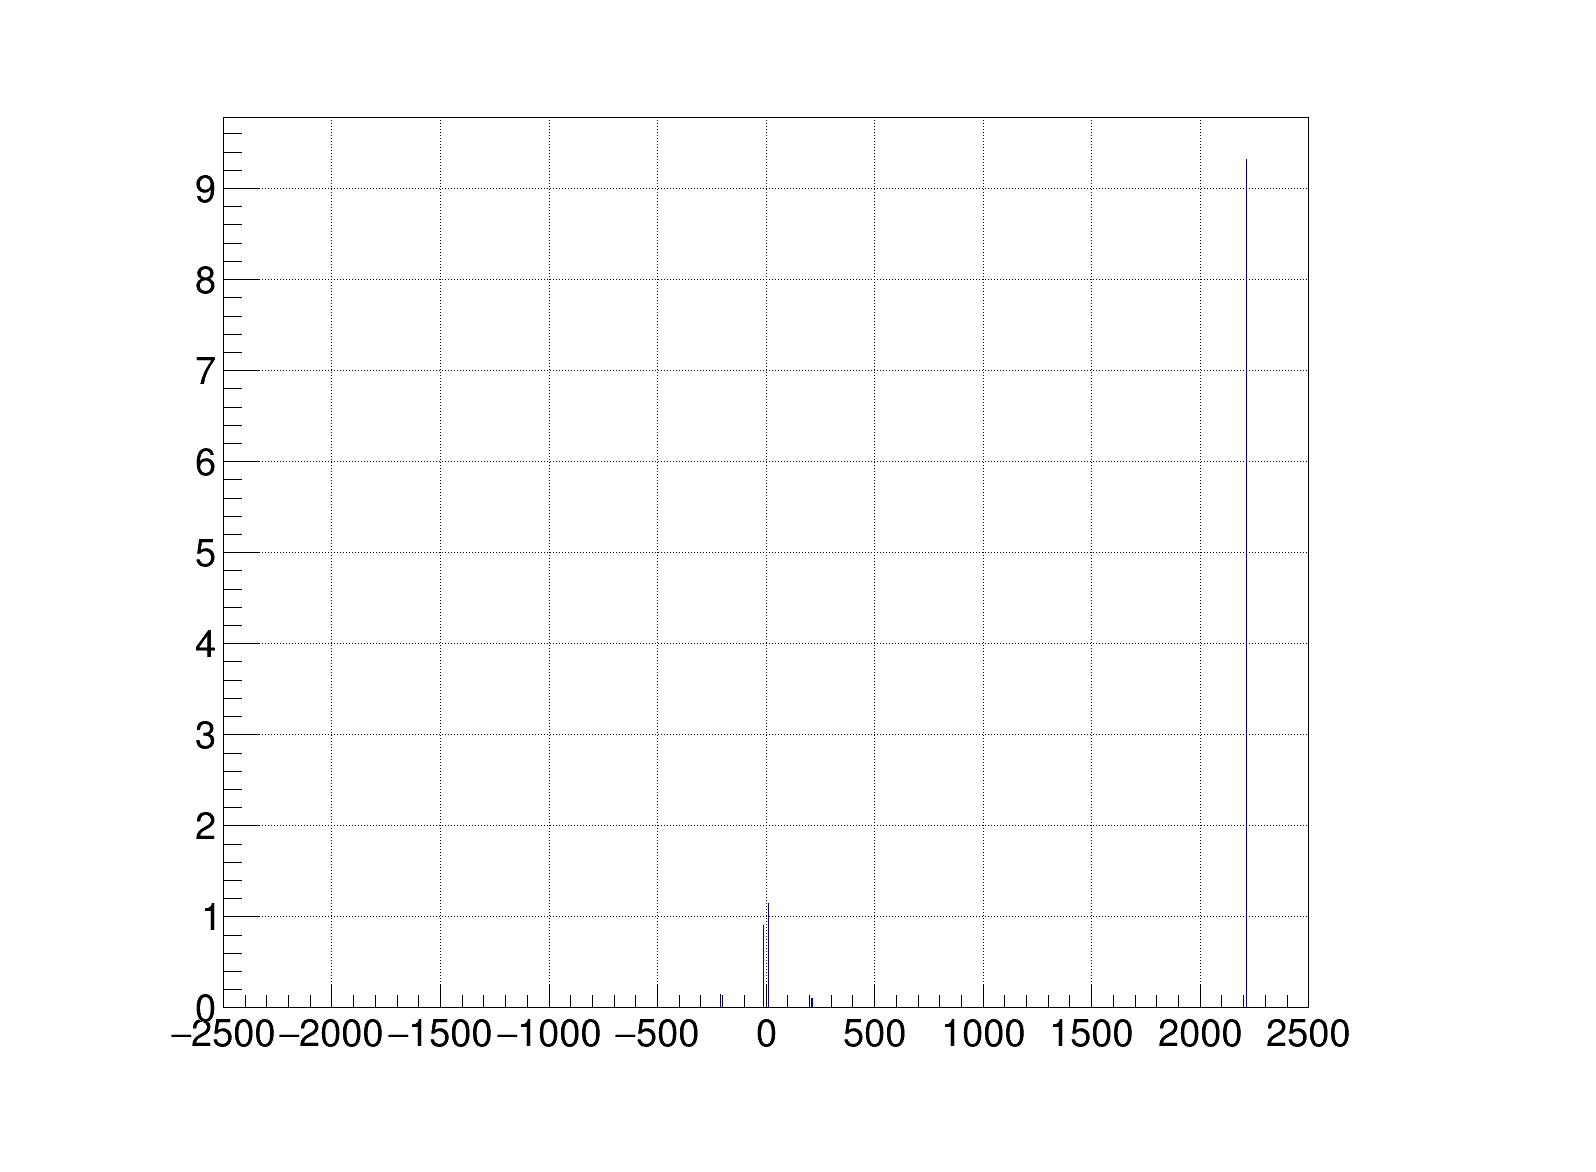

In [28]:
h_temp = ROOT.TH1F("h_temp",'h_temp',5000,-2500,2500)
overlay.Draw('MCTrackPDG>>h_temp',cut+' && MCTrackPurity>0.5 && sqrt( pow(TrackStart_x_sce - MCTrackStart_x,2) + \
    pow(TrackStart_y_sce - MCTrackStart_y,2) + pow(TrackStart_z_sce - MCTrackStart_z,2) )<15')
h_temp.Scale(scale)
for i in range(5000):
    num = h_temp.GetBinContent(i)
    if num!=0:
        print 'PDG: ',i-2500-1,' Numver of tracks: ',num

h_temp.Draw('hist')
c1.Draw()
#2212 = proton

Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp5 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/png/h_num_tracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/pdf/h_num_tracks.pdf has been created


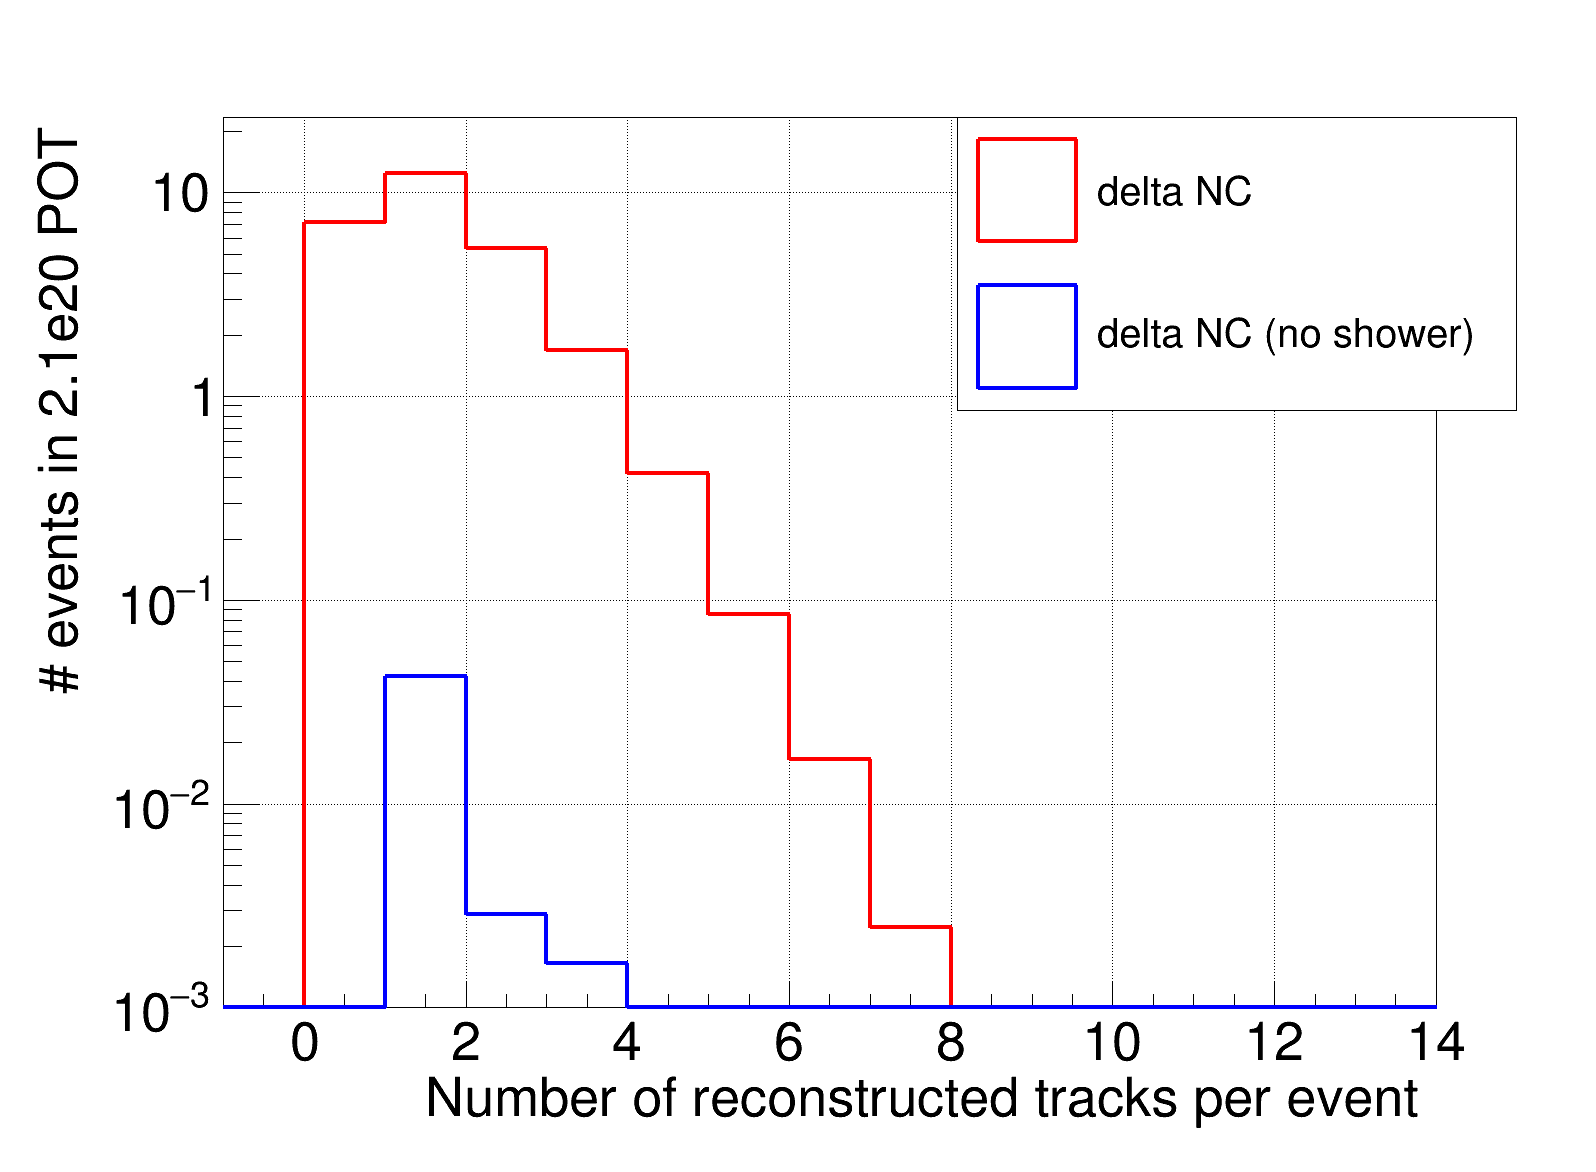

In [51]:
c1.SetRightMargin(0.1)
h_temp = ROOT.TH1F("h_temp",'h_temp',15,-1,14)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',15,-1,14)

h_temp2 = ROOT.TH1F("h_temp2",'h_temp',15,-1,14)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp1',15,-1,14)

h_temp4 = ROOT.TH1F("h_temp4",'h_temp4',15,-1,14)
h_temp5 = ROOT.TH1F("h_temp5",'h_temp5',15,-1,14)

ROOT.gStyle.SetPaintTextFormat("0.0f");


overlay.Draw('NuTracks'+'>>h_temp','fidVol','')
#ext.Draw('NuTracks'+'>>h_temp1','fidVol','')

h_temp.Scale(scale)
#h_temp1.Scale(scale_ext)

#h_temp1.Add(h_temp)


overlay.Draw('NuTracks'+'>>h_temp2','fidVol && NuShowers==0','')
#ext.Draw('NuTracks'+'>>h_temp3','fidVol && NuShowers==0','')

h_temp2.Scale(scale)
#h_temp3.Scale(scale_ext)

#h_temp3.Add(h_temp2)

overlay.Draw('NuTracks'+'>>h_temp4','fidVol && NuShowers==0','')
#ext.Draw('NuTracks'+'>>h_temp5','fidVol && NuShowers==0 && MCNu_PDG==12','')

h_temp4.Scale(scale)
#h_temp5.Scale(scale_ext)

#h_temp5.Add(h_temp4)

h_temp1.SetLineColor(ROOT.kBlack)
h_temp.SetLineColor(ROOT.kRed)
h_temp2.SetLineColor(ROOT.kBlue)
h_temp3.SetLineColor(ROOT.kGreen)
h_temp.SetLineWidth(4)
h_temp1.SetLineWidth(4)
h_temp2.SetLineWidth(4)
h_temp3.SetLineWidth(4)
h_temp4.SetLineWidth(4)
#h_temp5.SetLineWidth(4)

legend = ROOT.TLegend(0.6,0.65,0.95,0.9)
legend.AddEntry(h_temp,'delta NC',"f")
#legend.AddEntry(h_temp1,'All',"f")
legend.AddEntry(h_temp2,'delta NC (no shower)',"f")
#legend.AddEntry(h_temp3,'All (no shower)',"f")
#legend.AddEntry(h_temp4,'Overlay (+matched e)',"f")
#legend.AddEntry(h_temp5,'all',"f")
h_temp1 = h_temp.Clone()

h_temp1.SetXTitle("Number of reconstructed tracks per event")
h_temp1.SetYTitle("# events in 2.1e20 POT")
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)

h_temp1.SetMinimum(0.001)
h_temp1.Draw('hist')
h_temp.Draw('same hist')

#h_temp3.Draw('same hist')
h_temp2.Draw('same hist')

#h_temp5.Draw('same hist')
#h_temp4.Draw('same hist')
legend.Draw()


c1.SetLogy(1)
c1.Draw()
c1.SaveAs(outputdir_png + 'h_num_tracks.png')
#c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(x_theta)+'.root')
c1.SaveAs(outputdir_pdf + 'h_num_tracks.pdf')

Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/png/h_purity_tracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/pdf/h_purity_tracks.pdf has been created


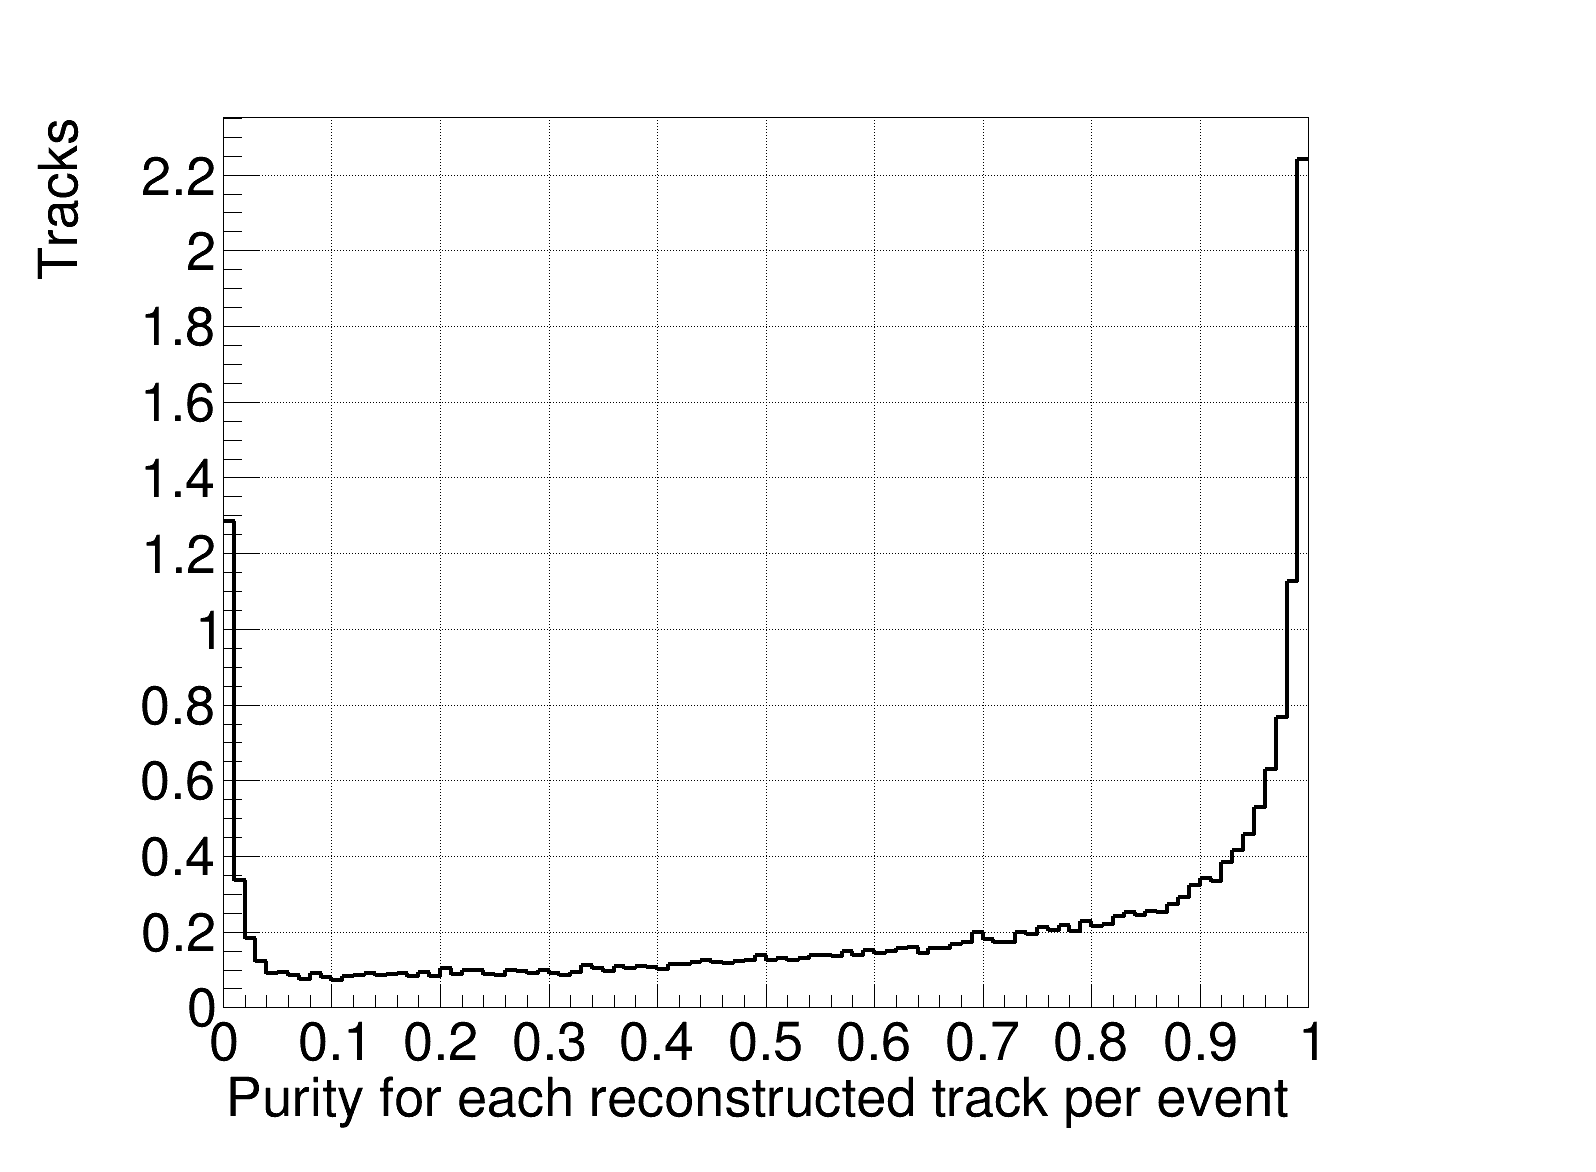

In [31]:
h_temp = ROOT.TH1F("h_temp",'h_temp',100,0,1)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',100,0,1)
c1.SetLogy(0)

overlay.Draw('MCTrackPurity'+'>>h_temp1','MCfidVol && fidVol','')
h_temp1.Scale(scale)
h_temp1.SetXTitle("Purity for each reconstructed track per event")
h_temp1.SetYTitle("Tracks")
h_temp1.SetLineColor(ROOT.kBlack)
h_temp1.SetLineWidth(4)
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)
h_temp1.Draw('hist')
c1.Draw()
c1.SaveAs(outputdir_png + 'h_purity_tracks.png')
c1.SaveAs(outputdir_pdf + 'h_purity_tracks.pdf')

Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/png/h_pdg_tracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/pdf/h_pdg_tracks.pdf has been created


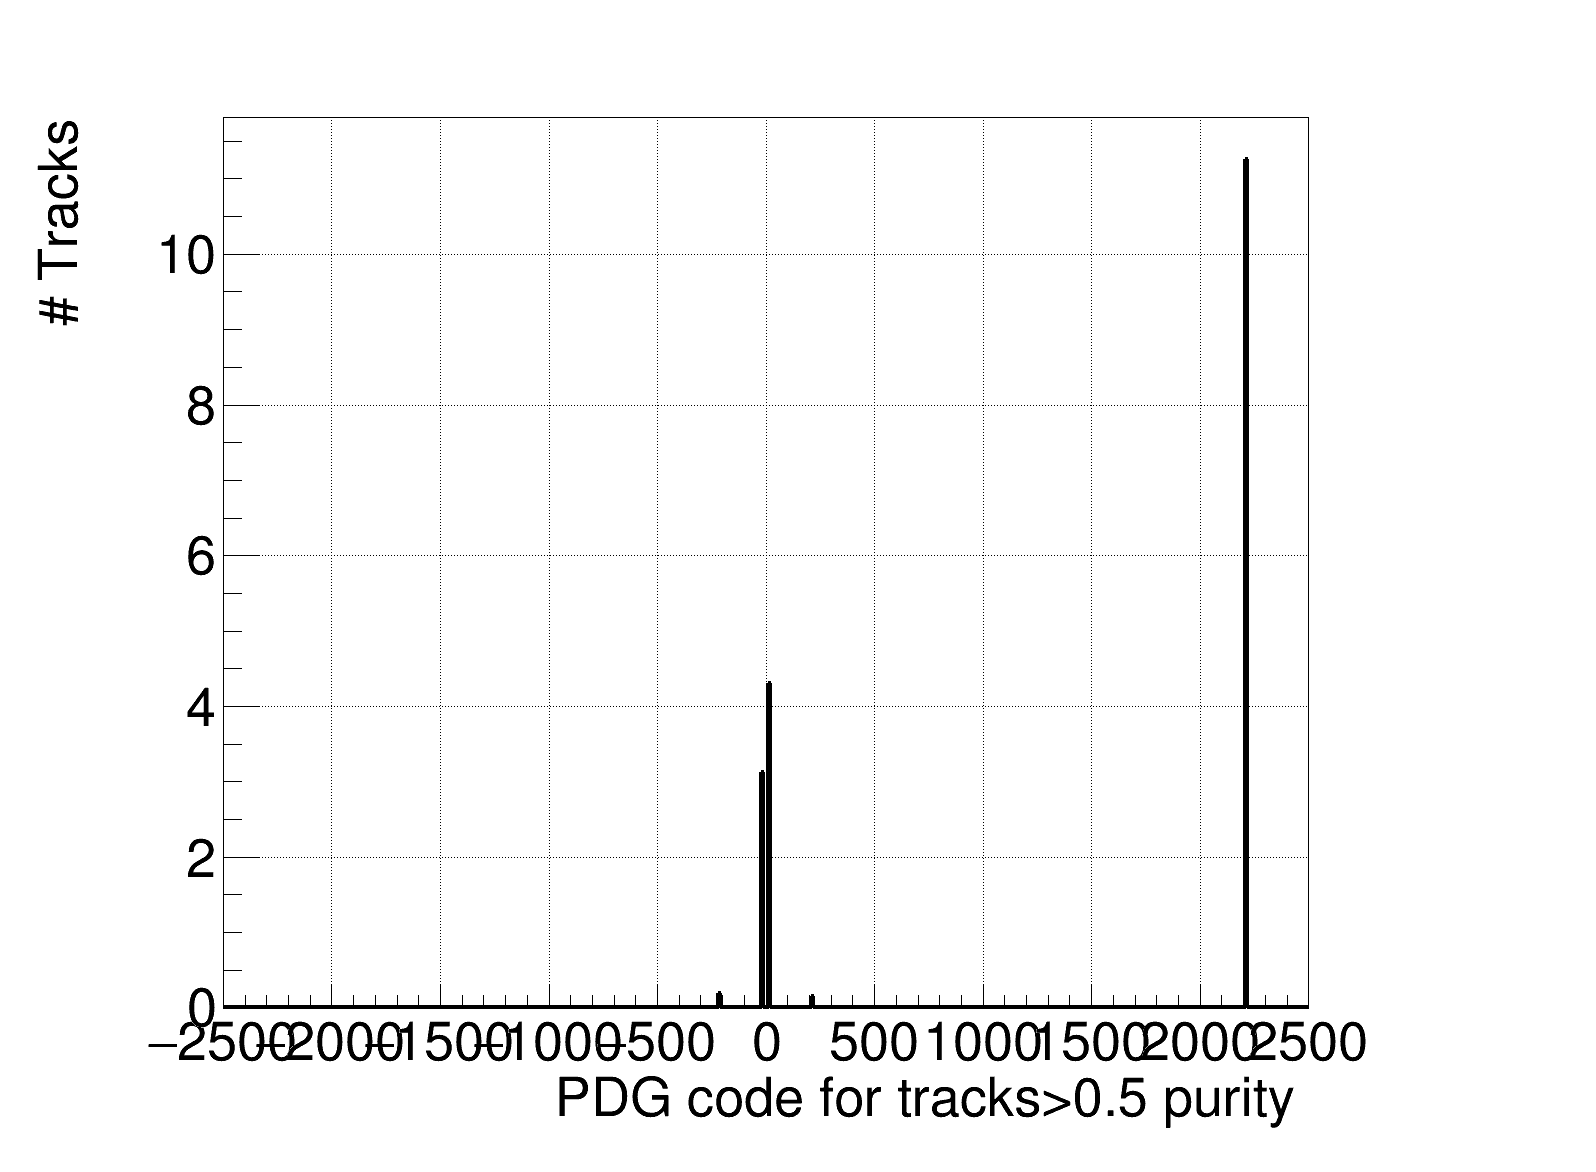

In [33]:
h_temp = ROOT.TH1F("h_temp",'h_temp',100,-500,500)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',500,-2500,2500)
c1.SetLogy(0)

overlay.Draw('MCTrackPDG'+'>>h_temp1','MCfidVol && fidVol && MCTrackPurity>0.5','')
h_temp1.Scale(scale)
h_temp1.SetXTitle("PDG code for tracks>0.5 purity")
h_temp1.SetYTitle("# Tracks")
h_temp1.SetLineColor(ROOT.kBlack)
h_temp1.SetLineWidth(4)
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)
h_temp1.Draw('hist')
c1.Draw()
c1.SaveAs(outputdir_png + 'h_pdg_tracks.png')
c1.SaveAs(outputdir_pdf + 'h_pdg_tracks.pdf')

Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp3 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/png/h_pdg_tracks_z.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_delta_check/pdf/h_pdg_tracks_z.pdf has been created


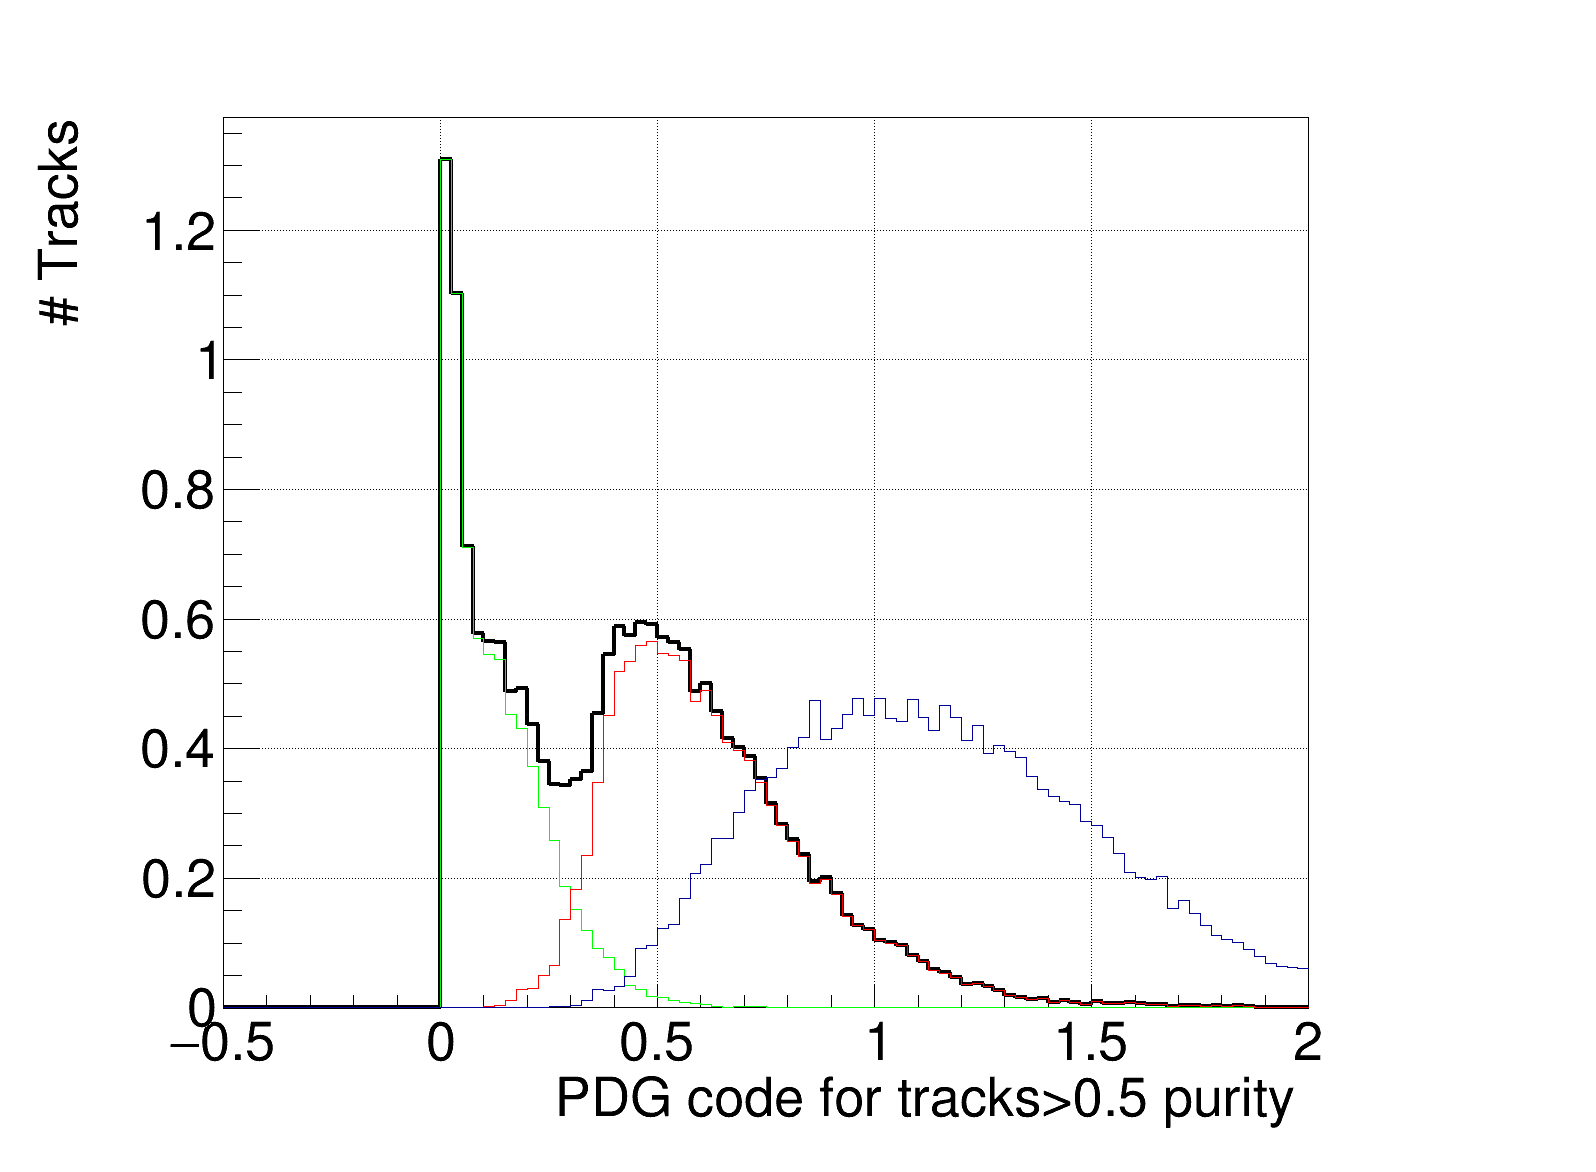

In [49]:
h_temp = ROOT.TH1F("h_temp",'h_temp',100,-0.5,2)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',100,-0.5,2)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',100,-0.5,2)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp3',100,-0.5,2)

c1.SetLogy(0)

overlay.Draw('MCTrackMomentum'+'>>h_temp1','MCfidVol && fidVol && MCTrackPurity>0.5','')
overlay.Draw('MCNu_Energy'+'>>h_temp','MCfidVol && fidVol && MCTrackPurity>0.5','')

overlay.Draw('MCTrackMomentum'+'>>h_temp2','MCfidVol && fidVol && MCTrackPurity>0.5 && abs(MCTrackPDG)==11','')
overlay.Draw('MCTrackMomentum'+'>>h_temp3','MCfidVol && fidVol && MCTrackPurity>0.5 && MCTrackPDG==2212')

h_temp1.Scale(scale)
h_temp2.Scale(scale)
h_temp3.Scale(scale)
h_temp.Scale(scale)
h_temp1.SetXTitle("PDG code for tracks>0.5 purity")
h_temp1.SetYTitle("# Tracks")
h_temp1.SetLineColor(ROOT.kBlack)
h_temp3.SetLineColor(ROOT.kRed)
h_temp2.SetLineColor(ROOT.kGreen)
h_temp1.SetLineWidth(4)
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)
h_temp1.Draw('hist')
h_temp2.Draw('hist same')
h_temp3.Draw('hist same')
h_temp.Draw('hist same')
c1.Draw()
c1.SaveAs(outputdir_png + 'h_pdg_tracks_z.png')
c1.SaveAs(outputdir_pdf + 'h_pdg_tracks_z.pdf')